In [1]:
import sys, importlib, time
sys.path.append('../../')

from src.Modules.Utils.Imports import *
from src.Modules.Models.BuildBINNs import BINN
from src.Modules.Utils.ModelWrapper import ModelWrapper
from src.Modules.Utils.Gradient import Gradient

#import src.Modules.Utils.PDESolver as PDESolver
import src.Modules.Loaders.DataFormatter as DF

from src.DE_simulation import fickian_diffusion, Diffusion_eqn, simple_pulling_diffusion, simple_adhesion_diffusion
#from scipy.integrate import odeint
from scipy.stats import qmc
from scipy.interpolate import RBFInterpolator
#import matplotlib.patches as mpatches
import numpy.matlib as matlib

from src.get_params import get_heterog_LHC_params_vary_Padh_Ppull_alpha

device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))

# helper functions
def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()


Device set to cpu


/home/hpc/nardinij/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
pde_weight = 1e4
path = '../../data/'

### BINN model information
save_folder = "../../Weights/"
model_name = 'DMLP'
weight = '_best_val'
pde_weight = 1e4
n = 25

Pp = 0.0
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

def load_model(binn_name, x, t, save_name):

    # instantiate BINN
    binn = BINN(binn_name,x, t).to(device)
    weight = '_best_val'
    
    # wrap model and load weights
    parameters = binn.parameters()
    model = ModelWrapper(
        model=binn,
        optimizer=None,
        loss=None,
        save_name=save_name)
    
    #model.save_name += '_' + binn.name + weight
    model.save_name += weight
    model.load(model.save_name + '_model', device=device)

    return model, binn


def BINN_diffusion_mesh(u_mesh,params):
    
    PmH, PmP, Pp, Padh, Ppull, alpha = params
    file_name = f'adhesion_pulling_mean_{n}_PmH_{PmH}_PmP_{PmP}_Pp_{Pp}_Padh_{Padh}_Ppull_{Ppull}_alpha_{alpha}'
    
    binn_name  = f"{model_name}"
    save_name =  f"BINN_training_{binn_name}_{file_name}_pde_weight_{pde_weight}"
    model,binn = load_model(binn_name=binn_name,save_name=save_folder + save_name,x=1.0,t=1.0)

    # evaluate parameter networks
    D_mesh = to_numpy(binn.diffusion(to_torch(u_mesh)[:, None]))
    
    return D_mesh

def unique_inputs(inputs):
    x = np.unique(inputs[:,0])
    t = np.unique(inputs[:,1])
    return x,t

def DE_sim(x, t, q, IC, Diffusion_function):
    
    sol = odeint(Diffusion_eqn, IC, t, args=(x, q, Diffusion_function))
    sol = sol.T
    
    return sol

def MSE(a,b):
    assert a.shape == b.shape
    return ((a - b)**2).mean()

def simulate_interpolant_PDE(params,f):

    PmH, PmP, Pp, Padh, Ppull, alpha = params
    
    def interpolated_diffusion(u):
        
        param_mesh = matlib.repmat(params,len(u),1)
        sampled_points_mesh = np.hstack([u[:,None], param_mesh])
        D_mesh_new = f(sampled_points_mesh)
        D_mesh_new[D_mesh_new < 0] = 0
        
        return D_mesh_new

    file_name = f'adhesion_pulling_mean_{n}_PmH_{PmH}_PmP_{PmP}_Pp_{Pp}_Padh_{Padh}_Ppull_{Ppull}_alpha_{alpha}'
    inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)

    x,t = unique_inputs(inputs)

    U = outputs.reshape((len(x),-1))
    IC = U[:,0]

    t0 = time.time()
    sol = DE_sim(x, 
                 t, 
                 [], 
                 IC, 
                 Diffusion_function = interpolated_diffusion)
        
    tf = time.time()-t0
    
    return x, t, sol, U, tf

In [3]:
u_mesh = np.linspace(0, 1, 101)[:,None]


#get LHC training sample
params_old = np.round(get_heterog_LHC_params_vary_Padh_Ppull_alpha("Training"),3)
#get LHC testing sample
params_new = np.round(get_heterog_LHC_params_vary_Padh_Ppull_alpha("Testing"),3)

count = 0
for params in params_old:
    D_mesh_tmp = BINN_diffusion_mesh(u_mesh,params)
    
    param_mesh_tmp = matlib.repmat(params,len(u_mesh),1)
    sampled_points_mesh_tmp = np.hstack([u_mesh, param_mesh_tmp])
    
    if count == 0:
        D_mesh = D_mesh_tmp
        sampled_points = sampled_points_mesh_tmp 
    else:
        D_mesh = np.vstack([D_mesh,D_mesh_tmp])
        sampled_points = np.vstack([sampled_points,sampled_points_mesh_tmp])
    count+=1 
    
D_mesh = np.squeeze(D_mesh)

f = RBFInterpolator(sampled_points, D_mesh, kernel="linear")
data = {}
data['f'] = f
np.save("../../results/PDE_sims/adhesion_pulling_interpolant.npy",data)

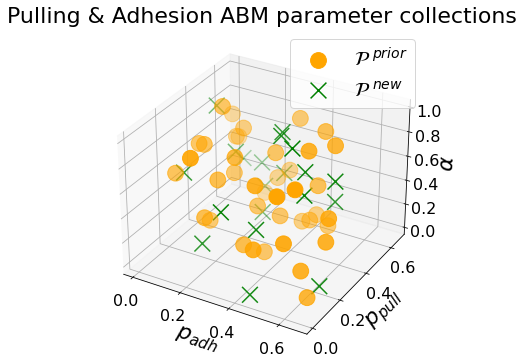

In [24]:
fig = plt.figure(figsize=(8,6))#, layout = "constrained")
ax = fig.add_subplot(projection='3d')
ax.scatter(params_old[:,3],params_old[:,4],params_old[:,5],s=250, color = "orange", label = "$\mathcal{P}^{ \ prior}$")
ax.scatter(params_new[:,3],params_new[:,4],params_new[:,5],s=250, color = "green", marker = "x", label = "$\mathcal{P}^{ \  new}$")

fontsize=22
plt.legend(fontsize=20)
plt.xlabel("$p_{adh}$",fontsize=fontsize)
plt.ylabel("$p_{pull}$",fontsize=fontsize)
ax.set_zlabel(r"$\alpha$",fontsize=fontsize)
plt.xticks(np.arange(0,.61,0.2),fontsize=16)
plt.yticks(np.arange(0,.61,0.2),fontsize=16)
ax.set_zticks(np.arange(0,1.1,0.2))
ax.set_zticklabels(np.round(np.arange(0,1.1,0.2),2),fontsize=16)
plt.title("Pulling & Adhesion ABM parameter collections",fontsize=fontsize)
plt.subplots_adjust(left=0)
plt.savefig("../../results/figures/Heterog_parameter_samplings.pdf",format="pdf")

8.938286926176618e-05
0.00012450607704513574

0.00012189994939605269
0.00014669272120592896

9.227439625477538e-05
0.00011859183339663332

7.064125401324901e-05
8.609835001284019e-05

7.68131611506067e-05
9.470262544288038e-05

0.00018538546767386314
0.0003004587072543211

0.0002707803050196347
0.00047161674618095877

0.00023059507691931098
0.00037044066555755507

0.0001609998145337409
0.0002555826998864811

7.295178074714476e-05
9.358725071558802e-05

0.0001285345989806344
0.0001912302616256062

0.00010963203539937067
0.00013681481905877547

9.601794996987471e-05
0.0001033604628064444

0.00013683157288727117
0.00019648189236455695

0.00018703536931451934
0.00012034990253478593

6.322036461445939e-05
8.244148310202048e-05

9.402599175294498e-05
0.00013864187263029558

6.436871015841866e-05
9.592122851866024e-05

9.42539336155067e-05
0.00014312079790580894

9.78033013090048e-05
0.00014420916329253516



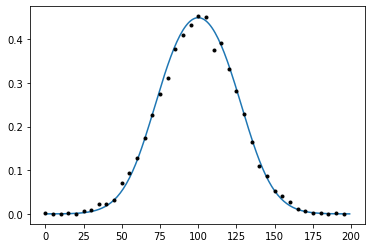

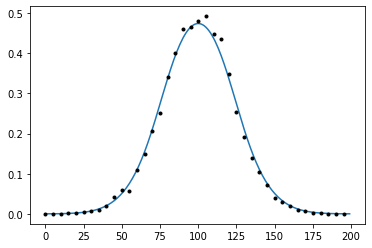

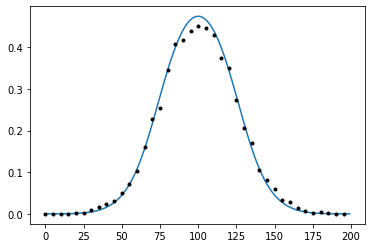

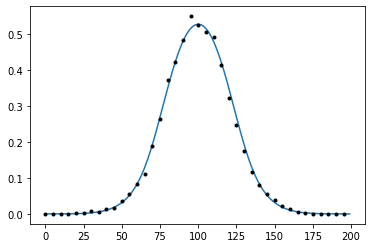

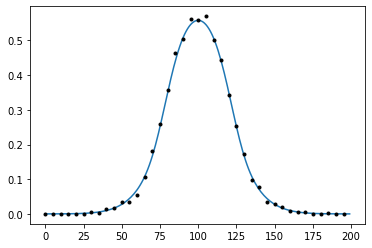

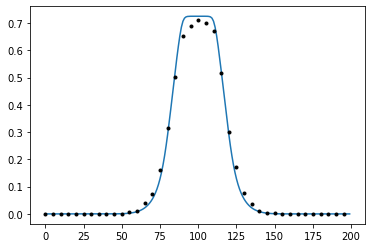

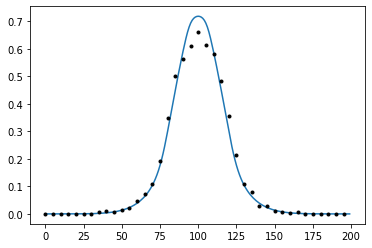

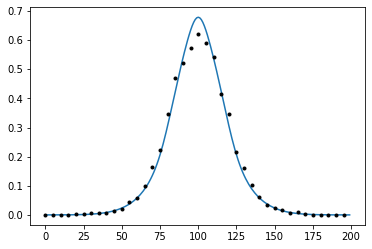

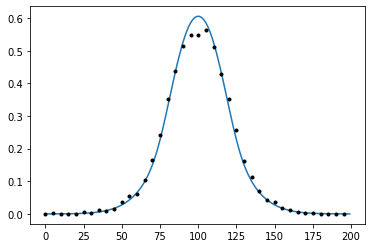

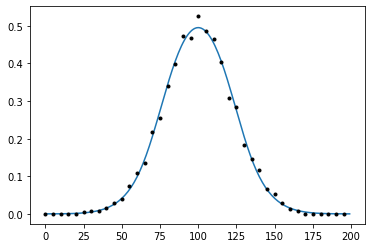

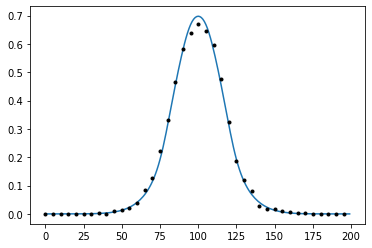

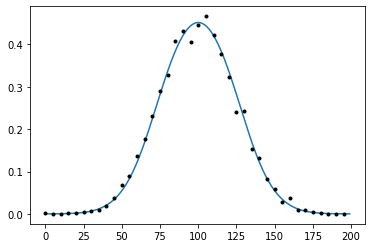

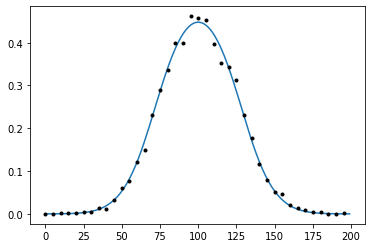

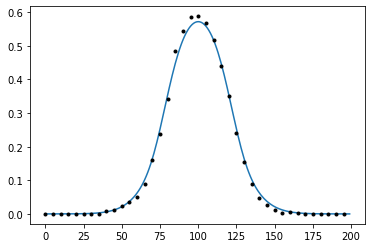

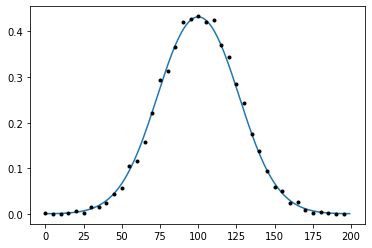

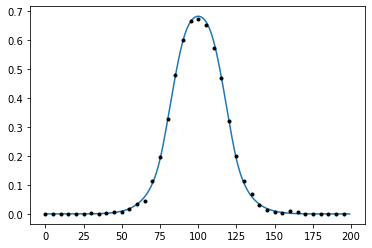

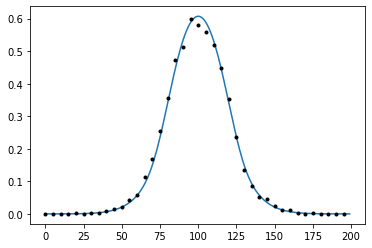

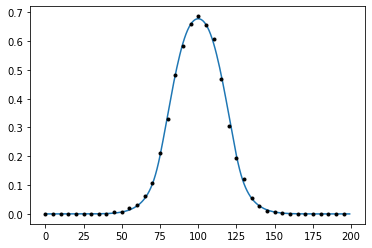

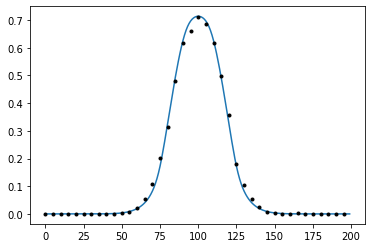

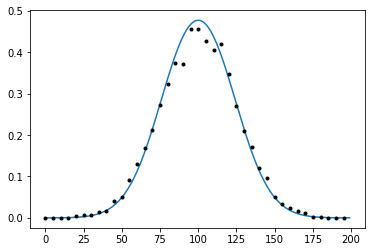

In [5]:
MSE_binn_trains = []
MSE_binn_tests = []
D_meshes = []

for params in params_new:
    x, t, sol, U, tf = simulate_interpolant_PDE(params,f)
    
    residual = sol - U
    MSE_binn_train = MSE(sol[:,t<=750],U[:,t<=750])
    MSE_binn_test  = MSE(sol[:,t> 750],U[:,t> 750])
    
    print(MSE_binn_train)
    print(MSE_binn_test)
    print("")
    
    plt.figure()
    plt.plot(x,sol[:,-1])
    plt.plot(x[::5],U[::5,-1],"k.")
    #plt.title(f"Train:{MSE_binn_train}")
    
    param_mesh = matlib.repmat(params,len(u_mesh),1)
    sampled_points_mesh = np.hstack([u_mesh, param_mesh])
    
    MSE_binn_trains.append(MSE_binn_train)
    MSE_binn_tests.append(MSE_binn_test)
    D_meshes.append(f(sampled_points_mesh))
MSE_binn_trains = np.array(MSE_binn_trains)
MSE_binn_tests = np.array(MSE_binn_tests)


<Figure size 576x432 with 0 Axes>

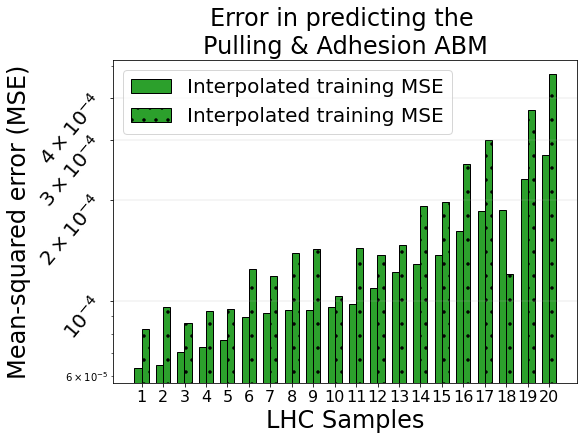

In [6]:
fontsize = 24

plt.figure(figsize=(8,6), layout='constrained')
MSE_sort_index = np.argsort(MSE_binn_trains)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(8,6),layout="constrained")
plt.bar(np.arange(len(MSE_binn_trains)), MSE_binn_trains[MSE_sort_index],color = colors[2], width = 0.33, log = True, edgecolor="k", label = "Interpolated training MSE")
plt.bar(np.arange(len(MSE_binn_trains))+.33, MSE_binn_tests[MSE_sort_index],color = colors[2], width = 0.33, log = True, hatch=".", edgecolor="k", label = "Interpolated training MSE")

xlabels = [f"{i}" for i in np.arange(1,len(MSE_binn_trains)+1)]
plt.xticks(np.arange(len(MSE_binn_trains))+.167, labels = xlabels, rotation = 0, fontsize=16)
plt.yticks([1e-4, 2e-4, 3e-4, 4e-4], rotation=50, fontsize=20)

plt.grid(axis="y", linewidth=0.25)

plt.xlabel("LHC Samples", fontsize=fontsize)
plt.ylabel("Mean-squared error (MSE)", fontsize=fontsize)
plt.title("Error in predicting the \nPulling & Adhesion ABM", fontsize=fontsize)
plt.legend(fontsize=20)

plt.savefig("../../results/figures/heterog_interpolation.pdf",format="pdf")

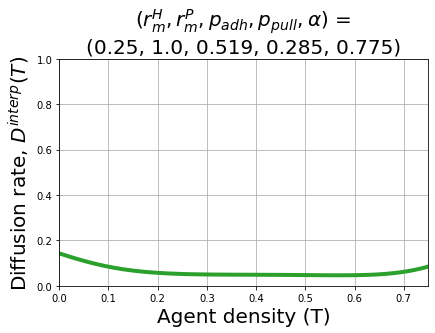

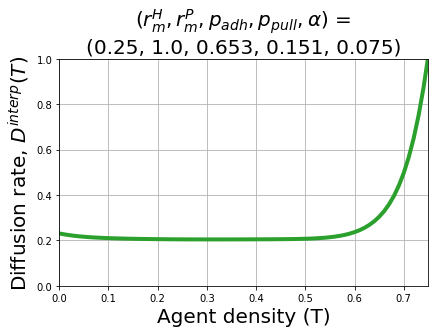

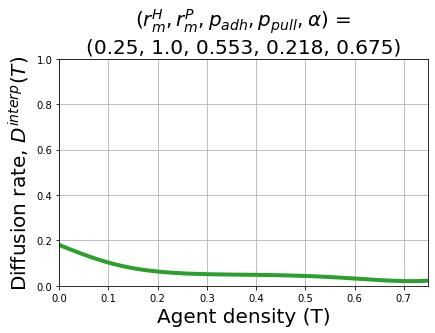

In [7]:
fontsize = 20

for i in [0,10,-1]:

    plt.figure()
    PmH, PmP, Pp, Padh, Ppull, alpha = params_new[MSE_sort_index[i]]

    plt.plot(u_mesh, D_meshes[MSE_sort_index[i]], c=colors[2], linewidth = 4)
    plt.grid()
    plt.xlim([0,0.75])
    plt.ylim([0,1.0])
    plt.tight_layout(pad=2)


    plt.xlabel("Agent density (T)",fontsize=fontsize)
    plt.ylabel("Diffusion rate, $D^{interp}(T)$",fontsize=fontsize)
    plt.title(r"$(r_m^H, r_m^P, p_{adh}, p_{pull}, \alpha)$ = "+f"\n{(PmH, PmP, Padh, Ppull, alpha)}",
              fontsize=fontsize)



### Make table of LHC samples

In [12]:
print("    \centering")
print(r"    \begin{tabular}{|c|c|}")
print("    \hline")
print("    Sample &   \\Pm = $\ (r_m^{pull},\ r_m^{adh},\ p_{pull},\ p_{adh},\ " + r"\alpha" + ")^T$ \\\\ \\hline")
for i in np.arange(len(MSE_sort_index)):
    index = MSE_sort_index[i]
    PmH, PmP, Pp, Padh, Ppull, alpha = params_new[MSE_sort_index[i]]
    print(f"    {i+1} &   ({PmP}, {PmH}, {Ppull}, {Padh}, {alpha})$^T$ \\\\ \\hline")
print("    \end{tabular}")    

    \centering
    \begin{tabular}{|c|c|}
    \hline
    Sample &   \Pm = $(r_m^{pull},\ r_m^{adh},\ p_{pull},\ p_{adh},\ \alpha)^T$ \\ \hline
    1 &   (1.0, 0.25, 0.285, 0.519, 0.775)$^T$ \\ \hline
    2 &   (1.0, 0.25, 0.419, 0.352, 0.875)$^T$ \\ \hline
    3 &   (1.0, 0.25, 0.486, 0.117, 0.525)$^T$ \\ \hline
    4 &   (1.0, 0.25, 0.553, 0.285, 0.375)$^T$ \\ \hline
    5 &   (1.0, 0.25, 0.385, 0.586, 0.475)$^T$ \\ \hline
    6 &   (1.0, 0.25, 0.586, 0.184, 0.175)$^T$ \\ \hline
    7 &   (1.0, 0.25, 0.62, 0.151, 0.325)$^T$ \\ \hline
    8 &   (1.0, 0.25, 0.184, 0.084, 0.625)$^T$ \\ \hline
    9 &   (1.0, 0.25, 0.352, 0.385, 0.925)$^T$ \\ \hline
    10 &   (1.0, 0.25, 0.653, 0.05, 0.275)$^T$ \\ \hline
    11 &   (1.0, 0.25, 0.151, 0.653, 0.075)$^T$ \\ \hline
    12 &   (1.0, 0.25, 0.452, 0.251, 0.125)$^T$ \\ \hline
    13 &   (1.0, 0.25, 0.084, 0.218, 0.225)$^T$ \\ \hline
    14 &   (1.0, 0.25, 0.318, 0.62, 0.725)$^T$ \\ \hline
    15 &   (1.0, 0.25, 0.519, 0.017, 0.825)$^T$ \\ \hline

In [18]:
def MSE(a,b):
    assert a.shape == b.shape
    return ((a - b)**2).mean()

MSE_vals = []
for params in params_old:
    
    PmH, PmP, Pp, Padh, Ppull, alpha = params
    mat = np.load(f"../../results/PDE_sims/PDE_sim_DMLP_adhesion_pulling_mean_25_PmH_{PmH}_PmP_{PmP}_Pp_0.0_Padh_{Padh}_Ppull_{Ppull}_alpha_{alpha}_pde_weight_10000.0.npy",allow_pickle=True).item()
    
    data = mat['U_data']
    sim  = mat['U_sim']
    t    = mat['t']
    
    MSE_vals.append(MSE(data[:,t<=750],sim[:,t<=750]))


In [22]:
MSE_old_train_sort_index = np.argsort(MSE_vals)

print("    \centering")
print(r"    \begin{tabular}{|c|c|}")
print("    \hline")
print("    Sample &   \\Pm = $\ (r_m^{pull},\ r_m^{adh},\ p_{pull},\ p_{adh},\ " + r"\alpha" + ")^T$ \\\\ \\hline")
for i in np.arange(len(MSE_old_train_sort_index)):
    index = MSE_old_train_sort_index[i]
    PmH, PmP, Pp, Padh, Ppull, alpha = params_old[MSE_old_train_sort_index[i]]
    print(f"    {i+1} &   ({PmP}, {PmH}, {Ppull}, {Padh}, {alpha})$^T$ \\\\ \\hline")
print("    \end{tabular}")    

    \centering
    \begin{tabular}{|c|c|}
    \hline
    Sample &   \Pm = $\ (r_m^{pull},\ r_m^{adh},\ p_{pull},\ p_{adh},\ \alpha)^T$ \\ \hline
    1 &   (1.0, 0.25, 0.394, 0.578, 0.912)$^T$ \\ \hline
    2 &   (1.0, 0.25, 0.293, 0.528, 0.938)$^T$ \\ \hline
    3 &   (1.0, 0.25, 0.008, 0.226, 0.988)$^T$ \\ \hline
    4 &   (1.0, 0.25, 0.511, 0.477, 0.862)$^T$ \\ \hline
    5 &   (1.0, 0.25, 0.41, 0.109, 0.962)$^T$ \\ \hline
    6 &   (1.0, 0.25, 0.075, 0.595, 0.888)$^T$ \\ \hline
    7 &   (1.0, 0.25, 0.042, 0.544, 0.838)$^T$ \\ \hline
    8 &   (1.0, 0.25, 0.327, 0.059, 0.712)$^T$ \\ \hline
    9 &   (1.0, 0.25, 0.444, 0.31, 0.662)$^T$ \\ \hline
    10 &   (1.0, 0.25, 0.209, 0.209, 0.612)$^T$ \\ \hline
    11 &   (1.0, 0.25, 0.126, 0.41, 0.762)$^T$ \\ \hline
    12 &   (1.0, 0.25, 0.193, 0.042, 0.588)$^T$ \\ \hline
    13 &   (1.0, 0.25, 0.059, 0.561, 0.462)$^T$ \\ \hline
    14 &   (1.0, 0.25, 0.243, 0.26, 0.788)$^T$ \\ \hline
    15 &   (1.0, 0.25, 0.427, 0.494, 0.512)$^T$ \\ \hlin